In [2]:
import numpy as np
from math import pi, sin, cos, acos, atan2, sqrt, fmod, exp
import matplotlib.pyplot as plt

## Trajutils.py

In [3]:
'''TrajUtils.py

   Trajectory (Spline) Utility Functions

   from TrajUtils import hold, interpolate, goto, spline, goto5, spline5

   The functions

      (p,v) = hold(             p0)                         Constant
      (p,v) = interpolate(t, T, p0, pf)                     Linear
      (p,v) = goto(       t, T, p0, pf)                     Cubic
      (p,v) = spline(     t, T, p0, pf, v0, vf)             Cubic
      (p,v) = goto5(      t, T, p0, pf)                     Quintic
      (p,v) = spline5(    t, T, p0, pf, v0, vf, a0, af)     Quintic

   each compute the position and velocity of the variable as a
   function of time.  They use a constant/linear.cubic/quintic
   polynomial with the given boundary conditions.  The arguments are:

       t       RELATIVE time of interest within the segment
       T       Total move time of the segment
       p0, pf  Initial/Final positions
       v0, vf  Initial/Final velocities
       a0, af  Initial/Final accelerations

       p, v    Resulting position/velocity for the time t

   NOTE TIME t IS RELATIVE, so make sure 0 <= t <= T.  Equivalently,
   the relative time advances from t=0 through t=T!

   The (p0,pf,v0,vf,a0,af) may be NumPy arrays and the (p,v) are
   returned with the appropriate (same) dimensions.

'''


#
#   Constant Helpers
#
#   This is really only included for completeness and to zero the
#   velocity (with the same dimension).
#
def hold(p0):
    # Compute the current (p,v).
    p = p0
    v = 0*p0
    return (p,v)


#
#   Linear Helpers
#
#   Linearly interpolate between an initial/final position of the time T.
#
def interpolate(t, T, p0, pf):
    # Compute the current (p,v).
    p = p0 + (pf-p0)/T * t
    v =    + (pf-p0)/T
    return (p,v)


#
#   Cubic Spline Helpers
#
#   Compute a cubic spline position/velocity as it moves from (p0, v0)
#   to (pf, vf) over time T.
#
#   Note  goto(t,T,p0,pf) = spline(t,T,p0,pf,0,0)  just faster.
#
#   Also, t  is the time of interest (different for each call)
#         T  is the total move time (keep the same between calls)
#         p0, pf, v0, vf  are the boundary conditions (also keep same)
#
def goto(t, T, p0, pf):
    # Compute the current (p,v).
    p = p0 + (pf-p0)   * (3*(t/T)**2 - 2*(t/T)**3)
    v =    + (pf-p0)/T * (6*(t/T)    - 6*(t/T)**2)
    return (p,v)

def spline(t, T, p0, pf, v0, vf):
    # Compute the parameters.
    a = p0
    b = v0
    c =   3*(pf-p0)/T**2 - vf/T    - 2*v0/T
    d = - 2*(pf-p0)/T**3 + vf/T**2 +   v0/T**2
    # Compute the current (p,v).
    p = a + b * t +   c * t**2 +   d * t**3
    v =     b     + 2*c * t    + 3*d * t**2
    return (p,v)


#
#   Quintic Spline Helpers
#
#   Compute a quintic spline position/velocity as it moves from
#   (p0,v0,a0) to (pf,vf,af) over time T.
#
#   Note  goto5(t,T,p0,pf) = spline5(t,T,p0,pf,0,0,0,0)  just faster.
#
def goto5(t, T, p0, pf):
    # Compute the current (p,v).
    p = p0 + (pf-p0)   * (10*(t/T)**3 - 15*(t/T)**4 +  6*(t/T)**5)
    v =    + (pf-p0)/T * (30*(t/T)**2 - 60*(t/T)**3 + 30*(t/T)**4)
    return (p,v)

def spline5(t, T, p0, pf, v0, vf, a0, af):
    # Compute the parameters.
    a = p0
    b = v0
    c = a0
    d = + 10*(pf-p0)/T**3 - 6*v0/T**2 - 3*a0/T    - 4*vf/T**2 + 0.5*af/T
    e = - 15*(pf-p0)/T**4 + 8*v0/T**3 + 3*a0/T**2 + 7*vf/T**3 -     af/T**2
    f = +  6*(pf-p0)/T**5 - 3*v0/T**4 -   a0/T**3 - 3*vf/T**4 + 0.5*af/T**3
    # Compute the current (p,v).
    p = a + b * t +   c * t**2 +   d * t**3 +   e * t**4 +   f * t**5
    v =     b     + 2*c * t    + 3*d * t**2 + 4*e * t**3 + 5*f * t**4
    return (p,v)


## Transformationhelper.py

In [4]:
'''TransformHelpers.py

   These are helper functions for rotation and transform matrices.

   They simply convert the information between different formats.  For
   example python lists or NumPy arrays, encoding Euler Angles,
   Quaternions, or Rotation Matrices.  The formats include:

      NumPy array 3     "p"     Point vector
      NumPy array 3     "n"     Axis (unit) vector
      NumPy array 3     "v"     Generic 3D Vector (e.g. linear/angular velocity)
      NumPy array 3     "e"     Error vector
      NumPy array 3x3   "R"     Rotation matrix
      NumPy array 4     "quat"  Quaternion (x,y,z,w)
      NumPy array 4x4   "T"     Transform matrix

   as well as the python list URDF tags <origin> and <axis>:

      Python List 3:    <axis>          Axis vector
      Python List 6:    <origin>        6D Transform Information
      Python List 3:    <origin> "xyz"  Vector of Positions
      Python List 3:    <origin> "rpy"  Vector of Euler Angles

   as well as the ROS message elements (types):

      ROS Message  Point        Point (x,y,z) in space
      ROS Message  Vector3      3D (x,y,z) vector
      ROS Message  Quaternion   Quaternion
      ROS Message  Pose         Point + Quaternion -> 3D Rigid Body definition
      ROS Message  Transform    Vector3 + Quaterion -> Frame to Frame shift
      ROS Message  Twist        Vector3 + Vector3 -> linear & angular velocity


   The Helper functions are:

   Cross Product:   cross(a,b)          Cross product of two 3-vectors
                    crossmat(a)         Cross product matrix

   Position         pzero()             Zero position vector
                    pxyz(x,y,z)         Position vector

   Axis Vectors     nx()                Unit x-axis
                    ny()                Unit y-axis
                    nz()                Unit z-axis
                    nxyz(x,y,z)         Unit vector

   Generic Vectors  vzero()             Zero vector
                    vxyz(x,y,z)         3D vector

   Rotation Matrix  Reye()              Identity rotation matrix
                    Rotx(alpha)         Rotation matrix about x-axis
                    Roty(alpha)         Rotation matrix about y-axis
                    Rotz(alpha)         Rotation matrix about z-axis
                    Rotn(n, alpha)      Rotation matrix about unit vector n

   Interpolation    pmid(p0,p1)         Return positoin halfway between p0,p1
                    Rmid(R0,R1)         Return rotation halfway between R0,R1
                    pinter(p0,p1,s)     Positon  factor s between p0,p1
                    Rinter(R0,R1,s)     Rotation factor s between R0,R1 
                    vinter(p0,p1,sdot)  Linear  velocity for pinter(p0,p1,s)
                    winter(R0,R1,sdot)  Angular velocity for Rinter(R0,R1,s)

   Error Vectors    ep(pd, p)           Translational error vector
                    eR(Rd, R)           Rotational error vector

   Transforms       Teye()              Identity T matrix
                    T_from_Rp(R,p)      Compose T matrix
                    p_from_T(T)         Extract position vector from T
                    R_from_T(T)         Extract rotation matrix from T

   Quaternions      quateye()                      Identity quaternion
                    quat_from_xyzw(x,y,z,w)        Create quat from (x,y,z,w)
                    quat_from_R(R)                 Convert R to quaternion
                    R_from_quat(quat)              Convert quaternion to R

   Axis/Angle       axisangle_from_R(R)            Convert R to (axis,angle)

   Roll/Pitch/Yaw   R_from_RPY(roll, pitch, yaw)   Construct R

   URDF Elements    T_from_URDF_origin(origin)     Construct transform
                    n_from_URDF_axis(axis)         Construct axis vector

   From ROS Msgs    p_from_Point(point)            Create p from Point msg
                    p_from_Vector3(vector3)        Create p from Vector3 msg
                    R_from_Quaternion(quaternion)  Create R from Quaternion msg
                    T_from_Pose(pose)              Create T from Pose msg
                    T_from_Transform(transform)    Create T from Transform msg

   To ROS Msgs      Point_from_p(p)                Create Point msg from p
                    Vector3_from_v(v)              Create Vector3 msg from v
                    Quaternion_from_R(R)           Create Quaternion msg from R
                    Pose_from_Rp(R,p)              Create Pose msg from R,p
                    Pose_from_T(T)                 Create Pose msg from T
                    Transform_from_Rp(R,p)         Create Transform msg from R,p
                    Transform_from_T(T)            Create Transform msg from T
                    Twist_from_vw(v,w)             Create Twist msg from v,w
'''

import numpy as np

#from urdf_parser_py.urdf        import Robot
# from geometry_msgs.msg          import Point, Vector3
# from geometry_msgs.msg          import Quaternion
# from geometry_msgs.msg          import Pose, Transform
# from geometry_msgs.msg          import Twist


#
#   Cross Product
#
def cross(a,b):
    return crossmat(a) @ b

def crossmat(a):
    return np.array([[  0.0, -a[2],  a[1]],
                     [ a[2],   0.0, -a[0]],
                     [-a[1],  a[0],  0.0]])


#
#   Position 3-Vector
#
def pzero():
    return np.zeros(3)

def pxyz(x,y,z):
    return np.array([x,y,z])


#
#   Axis (Unit 3-Vector)
#
def nx():
    return nxyz(1.0, 0.0, 0.0)
def ny():
    return nxyz(0.0, 1.0, 0.0)
def nz():
    return nxyz(0.0, 0.0, 1.0)
    
def nxyz(x,y,z):
    return np.array([x,y,z]) / np.sqrt(x*x+y*y+z*z)


#
#   Generic 3-Vector
#
def vzero():
    return np.zeros(3)

def vxyz(x,y,z):
    return np.array([x,y,z])


#
#   3x3 Rotation Matrix
#
def Reye():
    return np.eye(3)

def Rotx(alpha):
    return np.array([[1.0, 0.0          ,  0.0          ],
                     [0.0, np.cos(alpha), -np.sin(alpha)],
                     [0.0, np.sin(alpha),  np.cos(alpha)]])

def Roty(alpha):
    return np.array([[ np.cos(alpha), 0.0, np.sin(alpha)],
                     [ 0.0          , 1.0, 0.0          ],
                     [-np.sin(alpha), 0.0, np.cos(alpha)]])

def Rotz(alpha):
    return np.array([[np.cos(alpha), -np.sin(alpha), 0.0],
                     [np.sin(alpha),  np.cos(alpha), 0.0],
                     [0.0          ,  0.0          , 1.0]])

def Rotn(n, alpha):
    nx = crossmat(n)
    return np.eye(3) + np.sin(alpha) * nx + (1.0-np.cos(alpha)) * nx @ nx


#
#   Linear Interpolation (both linear and angular)
#
def pmid(p0, p1):
    return 0.5*(p0+p1)

def Rmid(R0, R1):
    return Rinter(R0, R1, 0.5)

def pinter(p0, p1, s):
    return p0 + (p1-p0)*s

def vinter(p0, p1, sdot):
    return      (p1-p0)*sdot

def Rinter(R0, R1, s):
    (axis, angle) = axisangle_from_R(R0.T @ R1)
    return R0 @ Rotn(axis, s*angle)

def winter(R0, R1, sdot): 
    (axis, angle) = axisangle_from_R(R0.T @ R1)
    return R0 @ axis * angle * sdot


#
#   Error 3-Vectors
#
def ep(pd, p):
    return (pd - p)

def eR(Rd, R):
    return 0.5 * (cross(R[0:3,0], Rd[0:3,0]) +
                  cross(R[0:3,1], Rd[0:3,1]) +
                  cross(R[0:3,2], Rd[0:3,2]))


#
#   4x4 Transform Matrix
#
#   Build the T matrix from R/P, or extract the R/p pieces.
#
def Teye():
    return np.eye(4)

def T_from_Rp(R, p):
    return np.vstack((np.hstack((R,p.reshape((3,1)))),
                      np.array([0.0, 0.0, 0.0, 1.0])))

def p_from_T(T):
    return T[0:3,3]
def R_from_T(T):
    return T[0:3,0:3]


#
#   Quaternions
#
#   Note quaterions are stored as [x,y,z,w]
#
#   Convert to/from a rotation matrix.
#
def quateye():
    return np.array([0,0,0,1])

def quat_from_xyzw(x,y,z,w):
    return np.array([x,y,z,w])

def quat_from_R(R):
    A = [1.0 + R[0][0] + R[1][1] + R[2][2],
         1.0 + R[0][0] - R[1][1] - R[2][2],
         1.0 - R[0][0] + R[1][1] - R[2][2],
         1.0 - R[0][0] - R[1][1] + R[2][2]]
    i = A.index(max(A))
    A = A[i]
    c = 0.5/np.sqrt(A)
    if   (i == 0):
        q = c*np.array([R[2][1]-R[1][2], R[0][2]-R[2][0], R[1][0]-R[0][1], A])
    elif (i == 1):
        q = c*np.array([A, R[1][0]+R[0][1], R[0][2]+R[2][0], R[2][1]-R[1][2]])
    elif (i == 2):
        q = c*np.array([R[1][0]+R[0][1], A, R[2][1]+R[1][2], R[0][2]-R[2][0]])
    else:
        q = c*np.array([R[0][2]+R[2][0], R[2][1]+R[1][2], A, R[1][0]-R[0][1]])
    return q

def R_from_quat(quat):
    norm2 = np.inner(quat,quat)
    v     = quat[0:3]
    w     = quat[3]
    R     = (2/norm2) * (np.outer(v,v) + w*w*Reye() + w*crossmat(v)) - Reye()
    return R



#
#   Axis/Angle
#
#   Pull the axis/angle from the rotation matrix.  For numberical
#   stability, go through the quaternion representation.
#
def axisangle_from_R(R):
    quat  = quat_from_R(R)
    v     = quat[0:3]
    w     = quat[3]
    n     = np.sqrt(np.inner(v,v))
    angle = 2.0 * np.arctan2(n, w)
    if n==0: axis = np.zeros(3)
    else:    axis = np.array(v) / n
    return (axis, angle)

#
#   Roll/Pitch/Yaw
#
#   Build a rotation matrix from roll/pitch/yaw angles.  These are
#   extrinsic Tait-Bryson rotations ordered roll(x)-pitch(y)-yaw(z).
#   To compute via the rotation matrices, we use the equivalent
#   intrinsic rotations in the reverse order.
#
def R_from_RPY(roll, pitch, yaw):
    return Rotz(yaw) @ Roty(pitch) @ Rotx(roll)


#
#   URDF <origin> element
#
#   The <origin> element should contain "xyz" and "rpy" attributes:
#     origin.xyz  x/y/z coordinates of the position
#     origin.rpy  Angles for roll/pitch/yaw or x/y/z extrinsic rotations
#
def p_from_URDF_xyz(xyz):
    return np.array(xyz)

def R_from_URDF_rpy(rpy):
    return R_from_RPY(rpy[0], rpy[1], rpy[2])

def T_from_URDF_origin(origin):
    return T_from_Rp(R_from_URDF_rpy(origin.rpy), p_from_URDF_xyz(origin.xyz))


#
#   URDF <axis> element
#
#   The <axis> element should contain only an "xyz" attribute.  Being
#   a single attribute, the parser directly presents this:
#     axis        x/y/z coordinates of the axis
#
def n_from_URDF_axis(axis):
    return np.array(axis)



#
#   From ROS Messages
#
#   Extract the info (re-organizing) from ROS message types
#
def p_from_Point(point):
    return pxyz(point.x, point.y, point.z)

def p_from_Vector3(vector3):
    return pxyz(vector3.x, vector3.y, vector3.z)

def quat_from_Quaternion(quaternion):
    return np.array([quaternion.x, quaternion.y, quaternion.z, quaternion.w])

def R_from_Quaternion(quaternion):
    return R_from_quat(quat_from_Quaternion(quaternion))

def T_from_Pose(pose):
    return T_from_Rp(R_from_Quaternion(pose.orientation),
                     p_from_Point(pose.position))

def T_from_Transform(transform):
    return T_from_Rp(R_from_Quaternion(transform.rotation),
                     p_from_Vector3(transform.translation))


#
#   To ROS Messages
#
#   Construct the ROS message types (re-organizing as appropriate).
#
def Point_from_p(p):
    return Point(x=p[0], y=p[1], z=p[2])

def Vector3_from_v(v):
    return Vector3(x=v[0], y=v[1], z=v[2])

def Quaternion_from_quat(quat):
    return Quaternion(x=quat[0], y=quat[1], z=quat[2], w=quat[3])

def Quaternion_from_R(R):
    return Quaternion_from_quat(quat_from_R(R))

def Pose_from_Rp(R,p):
    return Pose(position    = Point_from_p(p), 
                orientation = Quaternion_from_R(R))
def Pose_from_T(T):
    return Pose_from_Rp(R_from_T(T), p_from_T(T))

def Transform_from_Rp(R,p):
    return Transform(translation = Vector3_from_v(p),
                     rotation    = Quaternion_from_R(R))
def Transform_from_T(T):
    return Transform_from_Rp(R_from_T(T), p_from_T(T))

def Twist_from_vw(v,w):
    return Twist(linear  = Vector3_from_v(v),
                 angular = Vector3_from_v(w))

#
#   Constant Helpers
#
#   This is really only included for completeness and to zero the
#   velocity (with the same dimension).
#
def hold(p0):
    # Compute the current (p,v).
    p = p0
    v = 0*p0
    return (p,v)


#
#   Linear Helpers
#
#   Linearly interpolate between an initial/final position of the time T.
#
def interpolate(t, T, p0, pf):
    # Compute the current (p,v).
    p = p0 + (pf-p0)/T * t
    v =    + (pf-p0)/T
    return (p,v)


#
#   Cubic Spline Helpers
#
#   Compute a cubic spline position/velocity as it moves from (p0, v0)
#   to (pf, vf) over time T.
#
#   Note  goto(t,T,p0,pf) = spline(t,T,p0,pf,0,0)  just faster.
#
#   Also, t  is the time of interest (different for each call)
#         T  is the total move time (keep the same between calls)
#         p0, pf, v0, vf  are the boundary conditions (also keep same)
#
def goto(t, T, p0, pf):
    # Compute the current (p,v).
    p = p0 + (pf-p0)   * (3*(t/T)**2 - 2*(t/T)**3)
    v =    + (pf-p0)/T * (6*(t/T)    - 6*(t/T)**2)
    return (p,v)

def spline(t, T, p0, pf, v0, vf):
    # Compute the parameters.
    a = p0
    b = v0
    c =   3*(pf-p0)/T**2 - vf/T    - 2*v0/T
    d = - 2*(pf-p0)/T**3 + vf/T**2 +   v0/T**2
    # Compute the current (p,v).
    p = a + b * t +   c * t**2 +   d * t**3
    v =     b     + 2*c * t    + 3*d * t**2
    return (p,v)


#
#   Quintic Spline Helpers
#
#   Compute a quintic spline position/velocity as it moves from
#   (p0,v0,a0) to (pf,vf,af) over time T.
#
#   Note  goto5(t,T,p0,pf) = spline5(t,T,p0,pf,0,0,0,0)  just faster.
#
def goto5(t, T, p0, pf):
    # Compute the current (p,v).
    p = p0 + (pf-p0)   * (10*(t/T)**3 - 15*(t/T)**4 +  6*(t/T)**5)
    v =    + (pf-p0)/T * (30*(t/T)**2 - 60*(t/T)**3 + 30*(t/T)**4)
    return (p,v)

def spline5(t, T, p0, pf, v0, vf, a0, af):
    # Compute the parameters.
    a = p0
    b = v0
    c = a0
    d = + 10*(pf-p0)/T**3 - 6*v0/T**2 - 3*a0/T    - 4*vf/T**2 + 0.5*af/T
    e = - 15*(pf-p0)/T**4 + 8*v0/T**3 + 3*a0/T**2 + 7*vf/T**3 -     af/T**2
    f = +  6*(pf-p0)/T**5 - 3*v0/T**4 -   a0/T**3 - 3*vf/T**4 + 0.5*af/T**3
    # Compute the current (p,v).
    p = a + b * t +   c * t**2 +   d * t**3 +   e * t**4 +   f * t**5
    v =     b     + 2*c * t    + 3*d * t**2 + 4*e * t**3 + 5*f * t**4
    return (p,v)


## Code

In [5]:
import numpy as np

def q_to_R(x, y, z, w):
    """
    Convert a quaternion (x, y, z, w) to a 3x3 rotation matrix.
    Assumes (x, y, z) is the vector part and w is the scalar part.
    """
    # Normalize the quaternion to avoid scaling issues
    norm = np.sqrt(x*x + y*y + z*z + w*w)
    if norm == 0:
        raise ValueError("Zero-norm quaternion is not valid for rotation.")
    x /= norm
    y /= norm
    z /= norm
    w /= norm

    # Precompute products
    xx = x * x
    yy = y * y
    zz = z * z
    xy = x * y
    xz = x * z
    yz = y * z
    wx = w * x
    wy = w * y
    wz = w * z

    R = np.array([
        [1 - 2*(yy + zz),  2*(xy - wz),      2*(xz + wy)],
        [2*(xy + wz),      1 - 2*(xx + zz),  2*(yz - wx)],
        [2*(xz - wy),      2*(yz + wx),      1 - 2*(xx + yy)]
    ])

    return R


In [6]:
R=q_to_R(x=0.0, y=0.0, z=0.0, w=1.0)

In [7]:
R

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [8]:
def s(t):
    return goto5(t, 8.0, -1.0, 1.0)

In [9]:
smid, smiddot=goto5(4.0,8.0, 0.0, 2.0)
print('middle position is', smid, 'middle velocity is', smiddot)

middle position is 1.0 middle velocity is 0.46875


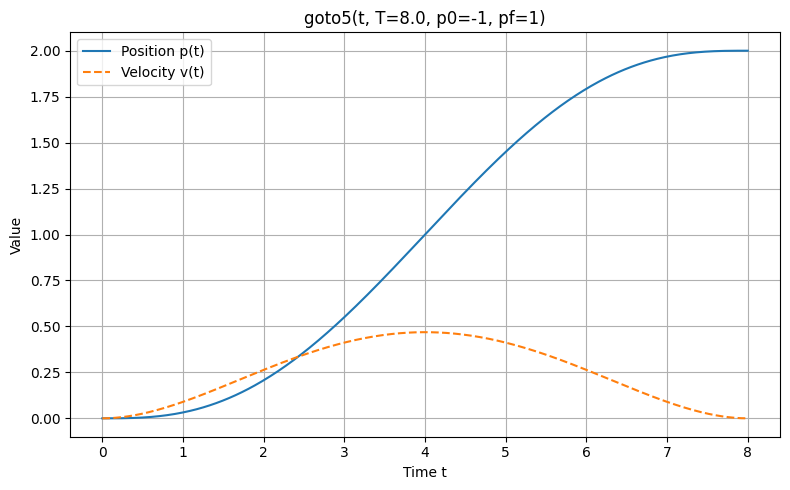

In [10]:
# Time vector
T=8.0
t = np.linspace(0, T, 500)
# Parameters
T = 8.0
p0 = -1.0
pf =  1.0

p,v = goto5(t, 8.0, 0.0, 2.0) 

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, p, label='Position p(t)')
plt.plot(t, v, label='Velocity v(t)', linestyle='--')

plt.xlabel('Time t')
plt.ylabel('Value')
plt.title('goto5(t, T=8.0, p0=-1, pf=1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
Rotx(-pi/2)@Roty(pi/2)

array([[ 6.12323400e-17,  0.00000000e+00,  1.00000000e+00],
       [-1.00000000e+00,  6.12323400e-17,  6.12323400e-17],
       [-6.12323400e-17, -1.00000000e+00,  3.74939946e-33]])